Calculation time:2.592 sec


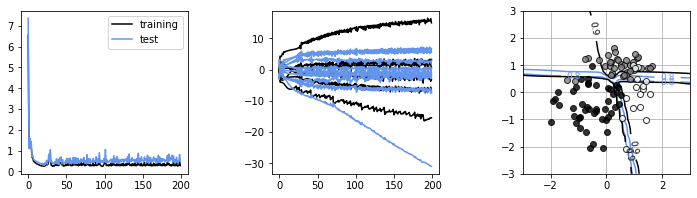

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

# 데이터 생성 --------------------------------
np.random.seed(seed=1) # 난수를 고정
N = 200 # 데이터의 수
K = 3 # 분포의 수
T = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3] # X0의 범위, 표시용
X_range1 = [-3, 3] # X1의 범위, 표시용
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi = np.array([0.4, 0.8, 1]) # 각 분포에 대한 비율
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T[n, k] = 1
            break
    for k in range(2):
        X[n, k] = np.random.randn() * Sig[T[n, :] == 1, k] + \
        Mu[T[n, :] == 1, k]
        
#-- 리스트 7-1-(2)
# -------- 2 분류 데이터를 테스트 훈련 데이터로 분할
TestRatio = 0.5
X_n_training = int(N * TestRatio)
X_train = X[:X_n_training, :]
X_test = X[X_n_training:, :]
T_train = T[:X_n_training, :]
T_test = T[X_n_training:, :]


# 데이터를 그리기 ------------------------------
def Show_data(x, t):
    wk, n = t.shape
    c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
    for i in range(n):
        plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
                 linestyle='none',
                 marker='o', markeredgecolor='black',
                 color=c[i], alpha=0.8)
    plt.grid(True)


    # 리스트 7-1-(4)
# 시그모이드 함수 ------------------------
def Sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y


# 네트워크 ------------------------
def FNN(wv, M, K, x):
    N, D = x.shape # 입력 차원
    w = wv[:M * (D + 1)] # 중간층 뉴런의 가중치
    w = w.reshape(M, (D + 1))
    v = wv[M * (D + 1):] # 출력층 뉴런의 가중치
    v = v.reshape((K, M + 1))
    b = np.zeros((N, M + 1)) # 중간층 뉴런의 입력 총합
    z = np.zeros((N, M + 1)) # 중간층 뉴런의 출력
    a = np.zeros((N, K)) # 출력층 뉴런의 입력 총합
    y = np.zeros((N, K)) # 출력층 뉴런의 출력
    for n in range(N):
        # 중간층의 계산
        for m in range(M):
            b[n, m] = np.dot(w[m, :], np.r_[x[n, :], 1]) # (A)
            z[n, m] = Sigmoid(b[n, m])
        # 출력층의 계산
        z[n, M] = 1 # 더미 뉴런
        wkz = 0
        for k in range(K):
            a[n, k] = np.dot(v[k, :], z[n, :])
            wkz = wkz + np.exp(a[n, k])
        for k in range(K):
            y[n, k] = np.exp(a[n, k]) / wkz
    return y, a, z, b


# 리스트 7-1-(5)
# 평균 교차 엔트로피 오차 ---------
def CE_FNN(wv, M, K, x, t):
    N, D = x.shape
    y, a, z, b = FNN(wv, M, K, x)
    ce = -np.dot(np.log(y.reshape(-1)), t.reshape(-1)) / N
    return ce



# 데이터를 그리기 ------------------------------
def Show_data(x, t):
    wk, n = t.shape
    c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
    for i in range(n):
        plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
                 linestyle='none',
                 marker='o', markeredgecolor='black',
                 color=c[i], alpha=0.8)
    plt.grid(True)


# 리스트 7-1-(10)
# 경계선 표시 함수 --------------------------
def show_FNN(wv, M, K):
    xn = 60 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, xn * xn, 1), np.reshape(xx1, xn * xn, 1)]
    y, a, z, b = FNN(wv, M, K, x)
    plt.figure(1, figsize=(4, 4))
    for ic in range(K):
        f = y[:, ic]
        f = f.reshape(xn, xn)
        f = f.T
        cont = plt.contour(xx0, xx1, f, levels=[0.8, 0.9],
                           colors=['cornflowerblue', 'black'])
        cont.clabel(fmt='%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
    



# 리스트 7-1-(11)
# -- 해석적 미분 -----------------------------------
def dCE_FNN(wv, M, K, x, t):
    N, D = x.shape
    # wv을 w와 v로 되돌림
    w = wv[:M * (D + 1)]
    w = w.reshape(M, (D + 1))
    v = wv[M * (D + 1):]
    v = v.reshape((K, M + 1))
    # ① x를 입력하여 y를 얻음
    y, a, z, b = FNN(wv, M, K, x)
    # 출력 변수의 준비
    dwv = np.zeros_like(wv)
    dw = np.zeros((M, D + 1))
    dv = np.zeros((K, M + 1))
    delta1 = np.zeros(M) # 1층 오차
    delta2 = np.zeros(K) # 2층 오차(k = 0 부분은 사용하지 않음)
    for n in range(N): # (A)
        # ② 출력층의 오차를 구하기
        for k in range(K):
            delta2[k] = (y[n, k] - t[n, k])
        # ③ 중간층의 오차를 구하기
        for j in range(M):
            delta1[j] = z[n, j] * (1 - z[n, j]) * np.dot(v[:, j], delta2)
        # ④ v의 기울기 dv를 구하기
        for k in range(K):
            dv[k, :] = dv[k, :] + delta2[k] * z[n, :] / N
        # ④ w의 기울기 dw를 구하기
        for j in range(M):
            dw[j, :] = dw[j, :] + delta1[j] * np.r_[x[n, :], 1] / N
    # dw와 dv를 합체시킨 dwv로 만들기
    dwv = np.c_[dw.reshape((1, M * (D + 1))), \
                dv.reshape((1, K * (M + 1)))]
    dwv = dwv.reshape(-1)
    return dwv


# 해석적 미분을 사용한 구배법 -------
def Fit_FNN(wv_init, M, K, x_train, t_train, x_test, t_test, n, rho):
    wv = wv_init.copy()
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))
    epsilon = 0.001
    alpha= 0.9
    g = np.zeros_like(wv)
    deltaWV = np.zeros_like(wv)
    r = np.zeros_like(wv)
    for i in range(n):
        g = dCE_FNN(wv, M, K, x_train, t_train) # (A)
        r = alpha*r + (1-alpha)*(g*g)
        deltaWV = - (rho/(epsilon + np.sqrt(r)))*g
        wv = wv + deltaWV;
        err_train[i] = CE_FNN(wv, M, K, x_train, t_train)
        err_test[i] = CE_FNN(wv, M, K, x_test, t_test)
        wv_hist[i, :] = wv
    return wv, wv_hist, err_train, err_test


# 메인 ---------------------------
startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 200
rho = 1
WV, WV_hist, Err_train, Err_test = Fit_FNN(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, rho)
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))


plt.figure(1, figsize=(12, 3))
plt.subplots_adjust(wspace=0.5)
# 학습 오차의 표시 ---------------------------
plt.subplot(1, 3, 1)
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label='test')
plt.legend()
# 가중치의 시간 변화 표시 ---------------------------
plt.subplot(1, 3, 2)
plt.plot(WV_hist[:, :M * 3], 'black')
plt.plot(WV_hist[:, M * 3:], 'cornflowerblue')
# 경계선 표시 --------------------------
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
M = 2
K = 3
show_FNN(WV, M, K)
plt.show()